# I. Introduction

- Dataset: https://data.world/crowdflower/brands-and-product-emotions
- Study Group: https://www.youtube.com/watch?v=mdBsuA95Luo
- Study Group GitHub:
    - https://github.com/learn-co-students/DS-PT-030220-Section39-NLP
    - https://www.kaggle.com/stoicstatic/twitter-sentiment-analysis-for-beginners


- Summary
    - Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion


- Build a model that can rate the sentiment of a Tweet based on its content.


- Aim for a Proof of Concept
    - There are many approaches to NLP problems - start with something simple and iterate from there. For example, you could start by limiting your analysis to positive and negative Tweets only, allowing you to build a binary classifier. Then you could add in the neutral Tweets to build out a multiclass classifier. You may also consider using some of the more advanced NLP methods in the Mod 4 Appendix.
    
- Evaluation
    - Evaluating multiclass classifiers can be trickier than binary classifiers because there are multiple ways to mis-classify an observation, and some errors are more problematic than others. Use the business problem that your NLP project sets out to solve to inform your choice of evaluation metrics.

# II. Importing

In [652]:
#import the packages that we will need for the project

import xgboost as xgb
import itertools
import math
import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
import numpy as np
import pandas as pd
plt.style.use('ggplot')


import nltk
from nltk.corpus import stopwords
import string
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, plot_confusion_matrix
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,confusion_matrix,classification_report
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier as xgbc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV as grid
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score,confusion_matrix,classification_report
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier as xgbc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV as grid
sm = SMOTE(random_state = 0)
vectorizer = TfidfVectorizer()
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB
import pandas as pd
import numpy as np
import seaborn as sns
wml = WordNetLemmatizer()
import re

# nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader.wordnet import NOUN
from nltk.corpus import wordnet

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import nltk
from wordcloud import WordCloud

# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report




In [603]:
#import the original dataset

df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')

df_train = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')
df_test = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding = 'unicode_escape')

# III. Data Cleaning

In [604]:
#check to see what the first 10 rows look like

df.head(n=5)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [605]:
#check to see the size of the dataset

df.shape

(9093, 3)

In [606]:
#take a deeper look at the composition of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [607]:
#rename the columns to make referencing them easier

df = df.rename(columns={'tweet_text': 'Tweet', 'emotion_in_tweet_is_directed_at': 'Brand',
'is_there_an_emotion_directed_at_a_brand_or_product': 'Sentiment'})

df.head(n=10)

,Tweet,Brand,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [608]:
df.Sentiment = df.Sentiment.map(lambda x: 'Positive' if x == 'Positive emotion' else 'Negative' if x == 'Negative emotion' else 'Neutral')
df

,Tweet,Brand,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,Neutral
9090,"Google's Zeiger, a physician never reported po...",NaN,Neutral
9091,Some Verizon iPhone customers complained their...,NaN,Neutral


In [609]:
df['Sentiment'].value_counts()

Neutral     5545
Positive    2978
Negative     570
Name: Sentiment, dtype: int64

In [610]:
df.isna().sum()

Tweet           1
Brand        5802
Sentiment       0
dtype: int64

In [611]:
df = df.drop('Brand', 1)

In [612]:
#check for null objects

df.isna().sum()

Tweet        1
Sentiment    0
dtype: int64

In [613]:
df.dropna(inplace=True)

In [614]:
df.isna().sum()

Tweet        0
Sentiment    0
dtype: int64

In [615]:
#check for duplicates

dups = df['Tweet'].duplicated()
print(dups.value_counts())

False    9065
True       27
Name: Tweet, dtype: int64


In [616]:
#drop the duplicates

df = df.drop_duplicates()
df.shape

(9070, 2)

In [617]:
df.head(n=5)

,Tweet,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive
3,@sxsw I hope this year's festival isn't as cra...,Negative
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive


## B. *Text Pre-Processing*

In [618]:
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [619]:
def process_article(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    return stopwords_removed   

In [620]:
tweets = df.loc[0:9000]['Tweet']
tweets

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
8996    Getting my ipad2 #sxsw (@mention Apple Store w...
8997    Data on my iPhone finally sorted. Next stop: #...
8998    {link} Guy Kawasaki talks 'Enchanted' at SXSW ...
8999    Brought my lunch and took train to #SXSW the l...
9000    Dropped my MacBook pro as I was walking into #...
Name: Tweet, Length: 8978, dtype: object

In [621]:
tweets_processed = list(map(process_article, tweets))

In [622]:
total_vocab = set()
for comment in tweets_processed:
    total_vocab.update(comment)
len(total_vocab)

10574

In [623]:
tweets_concat = []
for tweets in tweets_processed:
    tweets_concat += tweets

In [624]:
tweets_freqdist = FreqDist(tweets_concat)
tweets_freqdist.most_common(10)

[('sxsw', 9394),
 ('mention', 7052),
 ('link', 4267),
 ('rt', 2939),
 ('google', 2556),
 ('ipad', 2409),
 ('apple', 2286),
 ('quot', 1668),
 ('iphone', 1509),
 ('store', 1469)]

In [625]:
# Storing data in lists.
tweet, sentiment = list(df['Tweet']), list(df['Sentiment'])

In [626]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [627]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [628]:
processedtext = preprocess(tweet)

In [629]:
le = LabelEncoder()

df['Sentiment'] = le.fit_transform(df['Sentiment'])

In [630]:
df

,Tweet,Sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,2
2,@swonderlin Can not wait for #iPad 2 also. The...,2
3,@sxsw I hope this year's festival isn't as cra...,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,2
...,...,...
9088,Ipad everywhere. #SXSW {link},2
9089,"Wave, buzz... RT @mention We interrupt your re...",1
9090,"Google's Zeiger, a physician never reported po...",1
9091,Some Verizon iPhone customers complained their...,1


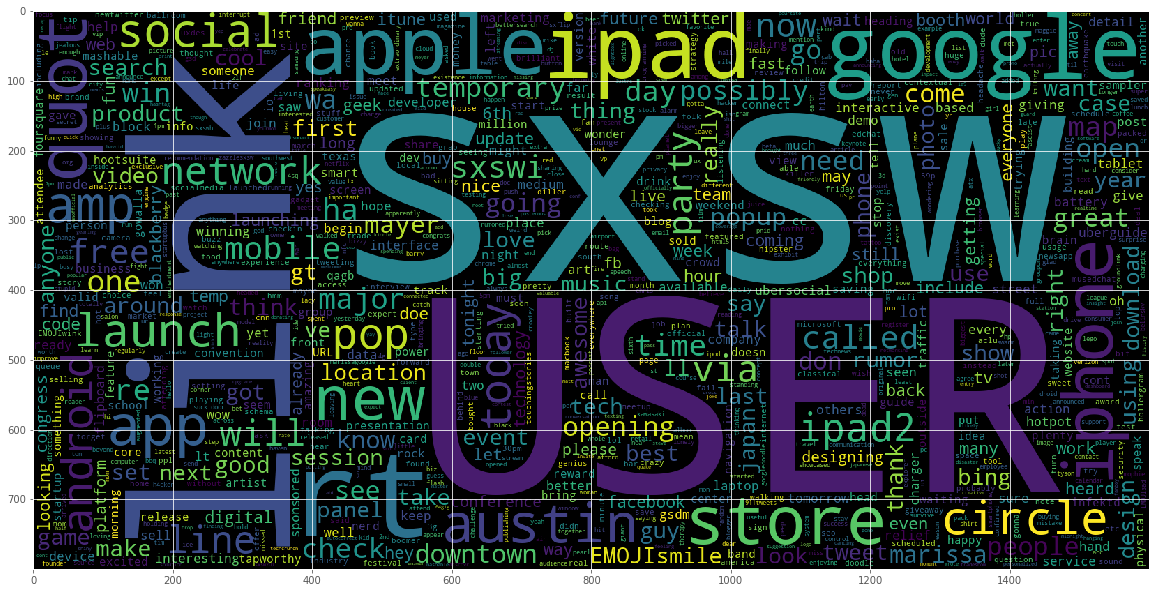

In [631]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

# IV. Data Exploration

## A. *Sentiment Distribution*

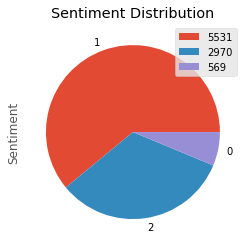

In [632]:
df['Sentiment'].value_counts().plot.pie()
plt.title('Sentiment Distribution')
plt.legend(df['Sentiment'].value_counts())

## B. *Product Distribution*

## C. *Tweets*

In [633]:
filenames = ['song' + str(i) + '.txt' for i in range(1, 21)]

In [634]:
tweets_df = pd.DataFrame()

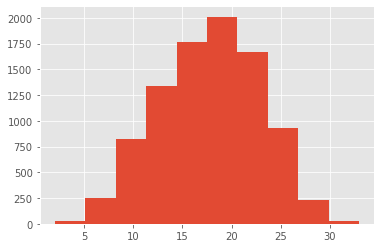

In [635]:
df['Tweet'].str.split().map(lambda x: len(x)).hist()

In [636]:
min(df['Tweet'].str.len()), max(df['Tweet'].str.len())

(11, 178)

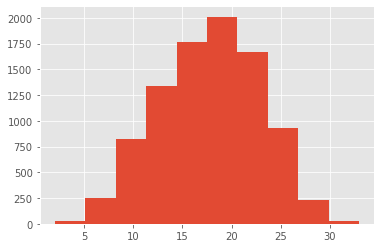

In [637]:
df['Tweet'].str.split().map(lambda x: len(x)).hist()

In [638]:
min(df['Tweet'].str.split().map(lambda x: len(x))), max(df['Tweet'].str.split().map(lambda x: len(x)))

(2, 33)

## C. *Apple vs. Google*

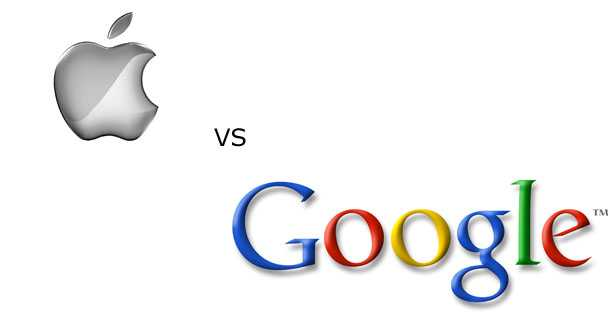

# V. Pre-Processing

In [645]:
# Grabbing our inputs and target
X = processedtext
y = df['Sentiment']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 0)

In [646]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [647]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

# VI. Models

In [681]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

## 1. BernoulliNB

In [682]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.66      0.99      0.79       286
           2       0.82      0.14      0.23       132

    accuracy                           0.67       454
   macro avg       0.49      0.38      0.34       454
weighted avg       0.65      0.67      0.57       454



/Users/cruzisiah/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 2. LinearSVC

In [683]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)

              precision    recall  f1-score   support

           0       0.59      0.28      0.38        36
           1       0.75      0.83      0.79       286
           2       0.56      0.52      0.54       132

    accuracy                           0.69       454
   macro avg       0.63      0.54      0.57       454
weighted avg       0.68      0.69      0.68       454



In [318]:
# Intstantiating our vectorizer
count_vectorizer = CountVectorizer()

# Training on the train set, then transforming the train set
X_count_train = count_vectorizer.fit_transform(X_train)
# Transforming the test set
X_count_test = count_vectorizer.transform(X_test)

In [319]:
# Instantiating a classifier to use on this text - Multinomial Naive Bayes
nb_classifier = MultinomialNB()

# Fitting the classifier
nb_classifier.fit(X_count_train, y_train)

# Getting our predictions for the train and test sets
train_preds = nb_classifier.predict(X_count_train)
test_preds = nb_classifier.predict(X_count_test)

Train Accuracy: 0.8179947074389885
Test Accuracy: 0.6781305114638448


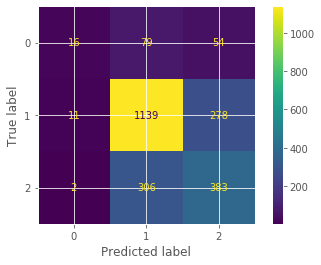

In [320]:
# Let's see how we did!
print(f"Train Accuracy: {accuracy_score(y_train, train_preds)}")
print(f"Test Accuracy: {accuracy_score(y_test, test_preds)}")
plot_confusion_matrix(nb_classifier, X_count_test, y_test, values_format='.4g')

In [321]:
def classify_vectorized_text(vectorizer, classifier, Xtrain, Xtest, ytrain, ytest):
    '''
    Fit and transform text data using the provided vectorizer, then fit and 
    predict with the provided classifier, in order to see the resulting
    accuracy score and confusion matrix
    For the Xtrain, Xtest, ytrain, ytest, expect the output of an
    sklearn train/test split
    -
    Inputs:
    vectorizer: an instantiated sklearn vectorizer
    classifier: an instantiated sklearn classifier
    X_train: training input data
    X_test: testing input data
    y_train: training true result
    y_test: testing true result
    -
    Outputs: 
    train_preds: predicted results for the train set
    test_preds: predicted results for the test set
    '''

    Xtrain_transformed = vectorizer.fit_transform(Xtrain)
    Xtest_transformed = vectorizer.transform(Xtest)

    classifier.fit(Xtrain_transformed, ytrain)

    train_preds = classifier.predict(Xtrain_transformed)
    test_preds = classifier.predict(Xtest_transformed)

    print(f"Train Accuracy: {accuracy_score(ytrain, train_preds)}")
    print(f"Test Accuracy: {accuracy_score(ytest, test_preds)}")
    plot_confusion_matrix(classifier, Xtest_transformed, ytest,
                          values_format=".4g")  # to make numbers readable
    plt.show()

    return(train_preds, test_preds)

In [322]:
# Instantiating a count vectorizer that does that extra something
count_stop = CountVectorizer(stop_words=stopwords_list)

Train Accuracy: 0.8215230814466333
Test Accuracy: 0.6763668430335097


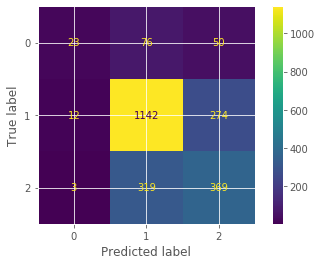

In [323]:
# Trying the same classifier, but now with stopwords removed
nb_stop = MultinomialNB()

# Using our function
stop_train_preds, stop_test_preds = classify_vectorized_text(
    count_stop, nb_stop, X_train, X_test, y_train, y_test)

- TF-IDF: Term-Frequency - Inverse Document-Frequency:

In [324]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, 
                        max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Training on the train set, then transforming the train set
tfidf_train = tfidf.fit_transform(X_train)
# Transforming the test set
tfidf_test = tfidf.transform(X_test)

In [325]:
# Here, number of rows is the length of our train set
tfidf_train

<6802x4565 sparse matrix of type '<class 'numpy.float64'>'
	with 68322 stored elements in Compressed Sparse Row format>

In [326]:
# Here, number of rows is the length of our test set
tfidf_test

<2268x4565 sparse matrix of type '<class 'numpy.float64'>'
	with 21851 stored elements in Compressed Sparse Row format>

In [327]:
# Creating a df of tf-idf values, where each column is a word in the vocabulary
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

In [328]:
tfidf_test_df

,00,000,00am,00pm,02,03,10,100,100s,101,...,ûï,ûïbest,ûïcheck,ûïcoming,ûïmore,ûïthe,ûò,ûòand,ûó,ûóthe
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2263,0.0,0.321957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2264,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2265,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2266,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [329]:
# Let's compare to our earlier count vectorizer for this document
# Need to fit/transform train and transform test (did this inside our function before)
count_stop_train = count_stop.fit_transform(X_train)
count_stop_test = count_stop.transform(X_test)

In [330]:
count_test_df = pd.DataFrame(count_stop_test.toarray(), columns=count_stop.get_feature_names())

In [331]:
count_vec16 = count_test_df.iloc[15]

count_vec16.loc[count_vec16 > 0]

called     1
circles    1
google     1
launch     1
link       1
major      1
mention    2
network    1
new        1
social     1
sxsw       1
via        1
Name: 15, dtype: int64

Train Accuracy: 0.7556600999705969
Test Accuracy: 0.6820987654320988


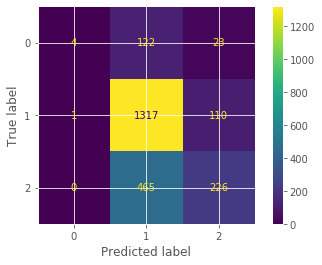

In [332]:
# Now, back to classifying:
# Using our function to compare the results...
nb_tfidf = MultinomialNB()

# Again, using our function
tfidf_train_preds, tfidf_test_preds = classify_vectorized_text(
    tfidf, nb_tfidf, X_train, X_test, y_train, y_test)

Train Accuracy: 0.9945604234048809
Test Accuracy: 0.6966490299823633


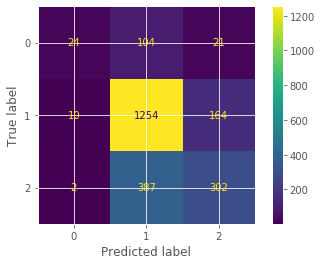

In [333]:
# We can also use our function to try different classifiers

rfc = RandomForestClassifier(n_estimators=100)

rfc_train_preds, rfc_test_preds = classify_vectorized_text(
    tfidf, rfc, X_train, X_test, y_train, y_test)

In [351]:
tweets_train = df
tweets_test = df
target = df.Target
test_target = df.Target

In [343]:
vectorizer = TfidfVectorizer()

In [344]:
tf_idf_data_train = vectorizer.fit_transform(df['Tweet'])

In [345]:
tf_idf_data_test = vectorizer.transform(df['Tweet'])

In [346]:
tf_idf_data_train.shape

(9070, 9780)

In [347]:
nb_classifier = MultinomialNB()
rf_classifier = RandomForestClassifier(n_estimators=100)

In [348]:
nb_classifier.fit(tf_idf_data_train, target)
nb_train_preds = nb_classifier.predict(tf_idf_data_train)
nb_test_preds = nb_classifier.predict(tf_idf_data_test)

In [349]:
rf_classifier.fit(tf_idf_data_train, target)
rf_train_preds = rf_classifier.predict(tf_idf_data_train)
rf_test_preds = rf_classifier.predict(tf_idf_data_test)

In [352]:
nb_train_score = accuracy_score(target, nb_train_preds)
nb_test_score = accuracy_score(test_target, nb_test_preds)
rf_train_score = accuracy_score(target, rf_train_preds)
rf_test_score = accuracy_score(test_target, rf_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))
print("")
print('-'*70)
print("")
print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

Multinomial Naive Bayes
Training Accuracy: 0.733 		 Testing Accuracy: 0.733

----------------------------------------------------------------------

Random Forest
Training Accuracy: 0.9958 		 Testing Accuracy: 0.9958


In [355]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

ValueError: could not convert string to float: "True story! RT @mention I just rated Amy's Ice Cream 5 stars. @mention &quot;Best ice cream in town!!&quot; {link} #sxsw"

## B. *Model Pre-Load*

In [ ]:
X = df.drop('Churn', axis=1, inplace=False)
y = df['Churn']

#separate the target variable from the data